# Import packages

In [1]:
import os
import shutil
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input
from tensorflow.keras import backend as K

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split



# Move files from subfolders into pathology and healthy datasets

In [2]:
# Extract the images of pathology from the various subfolders into one

#root_dir = '/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/Final project/GLENDA_v1.0/DS/pathology/frames'
#dest_dir = '/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/Final project/pathology_train'



#for folder in os.listdir(root_dir):
#   folder_path = os.path.join(root_dir, folder)
#    for filename in os.listdir(folder_path):
#            file_path = os.path.join(root_dir, folder, filename)
#            dest_path = os.path.join(dest_dir, filename+str(uuid.uuid4()))
#            shutil.copy(file_path, dest_path)
#            print("Copied ", file_path, "to", dest_path)


def extract_files_from_subfolders(root_directory, destination_directory):
    """
    Extracts files from subfolders in the root directory
    and places them into one folder aka destination directory. 
    The files are assigned a new random name to avoid overwriting.
    """
    for folder in os.listdir(root_directory):
        folder_path = os.path.join(root_directory, folder)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(root_directory, folder, filename)
            dest_path = os.path.join(destination_dir, filename+str(uuid.uuid4()))
            shutil.copy(file_path, dest_path)
            print("Copied ", file_path, "to", dest_path)


     


In [3]:
# Extract the images of non pathology from the various subfolders into one

#root_dir_healthy = '/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/Final project/GLENDA_v1.0/DS/no_pathology/frames'
#dest_dir_healthy = '/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/Final project/healthy_train'


#for folder in os.listdir(root_dir_healthy):
#    folder_path = os.path.join(root_dir_healthy, folder)
#    for filename in os.listdir(folder_path):
#            file_path = os.path.join(root_dir_healthy, folder, filename)
#            dest_path = os.path.join(dest_dir_healthy, filename+str(uuid.uuid4()))
#            shutil.copy(file_path, dest_path)
#            print("Copied ", file_path, "to", dest_path)


    

        


# Turn images into numpy arrays

## Try with 2000 samples from each class


In [4]:

X = []
y = []
classes = ['healthy', 'pathology']
base_path = '/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/Final project/'

for i, target in enumerate(classes):
    files = base_path+target+'/'
    for file in os.listdir(files):
        # load the image
        img = image.load_img(files+file)
        # convert it to an array
        img_array = image.img_to_array(img, dtype='uint8')
        # resize to fit resnet50
        img_array = cv2.resize(img_array, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        # append the array to X
        X.append(img_array)
        # append the target to y
        y.append(target)


X = np.array(X)
y = np.array(y)


               # image = np.expand_dims(image, axis=3)



In [5]:
y_dict = {'healthy':0, 'pathology':1}
y = np.vectorize(y_dict.get)(y)

## Shuffle the data

In [6]:
# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

In [7]:
X.shape, y.shape

((4446, 224, 224, 3), (4446,))

In [8]:
y

array([1, 1, 1, ..., 0, 1, 1])

# Built a basic model

## Split the data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.8, test_size=0.2)

In [10]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((3556, 224, 224, 3), (3556,), (890, 224, 224, 3), (890,))

In [11]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

((3556, 2), (890, 2))

In [12]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((3556, 224, 224, 3), (3556, 2), (890, 224, 224, 3), (890, 2))

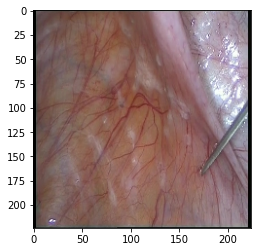

In [13]:
plt.imshow(X[0])

In [14]:
np.shape(X[0])

(224, 224, 3)

In [ ]:
type(X[0])

## Define the model

In [25]:
K.clear_session()
res_model = ResNet50(include_top=False,
                     weights="imagenet",
                     pooling='avg',
                     input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
res_model.summary()

In [26]:
# freeze it!
res_model.trainable = False

In [27]:
len(classes)

2

In [ ]:
model = Sequential()
model.add(res_model)

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 
# have a look at the trainable and non-trainable params statistic
model.summary()

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

## Fit the data

In [ ]:
# observe the validation loss and stop when it does not improve after 3 iterations
callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, 
                    epochs=50, 
                    verbose=2,
                    callbacks=[callback],
                    # use 30% of the data for validation
                    validation_split=0.3)

In [ ]:
history.history

## Save the model

In [ ]:
model.save('/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/Final project/web_app/model/model_endometriosis.h5')


## Visualise the performance

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
pred = model.predict(X_test)

In [ ]:
y_pred = np.argmax(pred, axis=1)
y_pred[2]

In [ ]:
y_test = np.argmax(y_test, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

In [ ]:
X_train[2].shape

In [ ]:
plt.imshow(X_train[2])

In [ ]:
y_test[2]

## Unseen data - validate

In [ ]:
model = models.load_model('/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/Final project/web_app/model/model_endometriosis.h5')

In [ ]:
def image_preproccess(file):
    img = image.load_img(file)
    # convert it to an array
    img_array = image.img_to_array(img, dtype='uint8')
    # resize to fit resnet50
    img_array = cv2.resize(img_array, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    # append the array to X
    return np.array(img_array)

    
    

In [ ]:
test_image = image_preproccess('/home/xrusa/Downloads/endome.png')

In [ ]:

test_image.shape

In [ ]:
plt.imshow(test_image)

In [ ]:
q = model.predict( np.array( [test_image,] )  )
q

In [ ]:
a = np.argmax(q, axis=1)
a

In [ ]:
if a == 1:
    print("pathology")
else:
    print("healthy")

In [ ]:
y_dict

In [ ]:
q = np.array([0.96803135, 0.03196873])

In [ ]:
np.amax(q)

In [ ]:
np.max(q) * 100 

In [ ]:
np.round(np.max(q) * 100 )

# Tensorboard

In [1]:
%load_ext tensorboard

In [2]:
import tensorflow as tf
import datetime

In [17]:
 model = models.load_model('/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/Final project/web_app/model/model_endometriosis.h5')

2022-03-07 22:58:19.036797: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 22:58:19.039682: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [18]:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=X_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(X_test, y_test), 
          callbacks=[tensorboard_callback])


2022-03-07 22:58:26.594902: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-07 22:58:26.594934: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-07 22:58:26.597176: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2022-03-07 22:58:27.255477: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
  1/112 [..............................] - ETA: 12:14 - loss: 9.4059e-04 - accuracy: 1.0000

2022-03-07 22:58:34.205063: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-07 22:58:34.205161: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/112 [..............................] - ETA: 5:36 - loss: 0.0222 - accuracy: 1.0000     

2022-03-07 22:58:37.082755: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-07 22:58:37.125358: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-07 22:58:37.152702: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20220307-225826/train/plugins/profile/2022_03_07_22_58_37

2022-03-07 22:58:37.160448: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20220307-225826/train/plugins/profile/2022_03_07_22_58_37/xrusa-UX310UA.trace.json.gz
2022-03-07 22:58:37.204622: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20220307-225826/train/plugins/profile/2022_03_07_22_58_37

2022-03-07 22:58:37.208236: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20220307-225826/train/plugins/profile/2022

112/112 [==============================] - 372s 3s/step - loss: 0.0186 - accuracy: 0.9933 - val_loss: 0.0408 - val_accuracy: 0.9809
Epoch 2/5
112/112 [==============================] - 368s 3s/step - loss: 0.0139 - accuracy: 0.9958 - val_loss: 0.0110 - val_accuracy: 0.9978
Epoch 3/5
112/112 [==============================] - 368s 3s/step - loss: 8.6714e-04 - accuracy: 1.0000 - val_loss: 0.0172 - val_accuracy: 0.9966
Epoch 4/5
112/112 [==============================] - 361s 3s/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0108 - val_accuracy: 0.9978
Epoch 5/5
112/112 [==============================] - 364s 3s/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.0146 - val_accuracy: 0.9978


In [3]:
%tensorboard --logdir logs/fit

In [22]:
from tensorboard.plugins.hparams import api as hp

In [28]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_L_RATE= hp.HParam('learning_rate', hp.Discrete([0.01, 0.001]))

METRIC_ACCURACY = 'accuracy'


In [46]:
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )


In [52]:
def train_test_model(hparams):
    model = Sequential()
    model.add(res_model)
    model.add(Dense(hparams[HP_NUM_UNITS], activation='relu'))
    model.add(Dropout(hparams[HP_DROPOUT]))
    model.add(Dense(len(classes), activation='softmax'))
    
    model.compile(
        optimizer=hparams[HP_OPTIMIZER],
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    model.fit(X_train, y_train, epochs=1) # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(X_test, y_test)
    return accuracy


In [53]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)


In [54]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
      for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DROPOUT: dropout_rate,
                HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1


--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.2, 'optimizer': 'adam'}
28/28 [==============================] - 73s 3s/step - loss: 0.0455 - accuracy: 0.9888
--- Starting trial: run-1
{'num_units': 64, 'dropout': 0.2, 'optimizer': 'sgd'}
28/28 [==============================] - 73s 3s/step - loss: 0.1803 - accuracy: 0.9180
--- Starting trial: run-2
{'num_units': 64, 'dropout': 0.3, 'optimizer': 'adam'}
28/28 [==============================] - 74s 3s/step - loss: 0.0635 - accuracy: 0.9820
--- Starting trial: run-3
{'num_units': 64, 'dropout': 0.3, 'optimizer': 'sgd'}
28/28 [==============================] - 77s 3s/step - loss: 0.4394 - accuracy: 0.7674
--- Starting trial: run-4
{'num_units': 128, 'dropout': 0.2, 'optimizer': 'adam'}
28/28 [==============================] - 86s 3s/step - loss: 0.0334 - accuracy: 0.9921
--- Starting trial: run-5
{'num_units': 128, 'dropout': 0.2, 'optimizer': 'sgd'}
28/28 [==============================] - 77s 3s/step - loss: 0.1676 - accuracy: 

In [5]:
%tensorboard --logdir logs/hparam_tuning

Reusing TensorBoard on port 6007 (pid 6029), started 0:07:13 ago. (Use '!kill 6029' to kill it.)